In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot
import sys
import h5py

In [2]:
sys.path.append('/home/surajrai1900/iwcd_gbdt')
sys.path.append('/home/surajrai1900/WatChMaL')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import bdt_analysis
import train_test_tree
import utils
import analysis.utils.math as math
from analysis.read import FiTQunOutput
import analysis.utils.binning as bins

/home/surajrai1900/WatChMaL/analysis/__init__.py:4: UserWarning: WARNING: The git repository has uncommitted changes. Please commit changes before running WatChMaL code for proper version control
  print(f"Imported analysis code from WatChMaL repository with git version: {get_git_version(os.path.dirname(__file__))}")


Imported analysis code from WatChMaL repository with git version: 0ed2fbb-dirty


In [5]:
idxs_path = '/home/pdeperio/machine_learning/data/IWCD_mPMT_Short/index_lists/4class_e_mu_gamma_pi0/IWCD_mPMT_Short_4_class_3M_emgp0_idxs.npz'
test_idxs  =  np.load(idxs_path, allow_pickle=True)['test_idxs']
data_path = "/home/pdeperio/machine_learning/data/IWCD_mPMT_Short/IWCD_mPMT_Short_emgp0_E0to1000MeV_digihits.h5"
h5_file = h5py.File(data_path, "r")

In [6]:
h5_angles     = np.array(h5_file['angles'])[test_idxs].squeeze()
h5_energies   = np.array(h5_file['energies'])[test_idxs].squeeze()
h5_positions  = np.array(h5_file['positions'])[test_idxs].squeeze()
h5_labels     = np.array(h5_file['labels'])[test_idxs].squeeze()
h5_root_files = np.array(h5_file['root_files'])[test_idxs].squeeze()
h5_event_ids  = np.array(h5_file['event_ids'])[test_idxs].squeeze()
h5_vetos      = np.array(h5_file['veto'])[test_idxs].squeeze()
events_hits_index = np.append(h5_file['event_hits_index'], h5_file['hit_pmt'].shape[0])
h5_nhits      = (events_hits_index[test_idxs+1] - events_hits_index[test_idxs]).squeeze()

In [7]:
# create dictionary with keys of the unique root_files
root_file_index = dict.fromkeys(h5_root_files)
# update the values so each root file key has a value from 0 to the number of files
root_file_index.update((k, i) for i, k in enumerate(root_file_index))
# create array of root_file_indices of each event in the h5_root_files array
root_file_indices = np.vectorize(root_file_index.__getitem__)(h5_root_files)
# create the array of offsets from the root_file_indices and the h5_event_ids
h5_fq_offsets = 3000*root_file_indices + h5_event_ids

In [8]:
file_path = '/home/pdeperio/machine_learning/data/IWCD_mPMT_Short/fiTQun/'
labels = ['gamma', 'e-', 'mu-', 'pi0']
labels_index = [0, 1, 2, 3]
fq_files = [file_path + f'IWCD_mPMT_Short_{i}_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root' for i in labels]

In [9]:
fq = FiTQunOutput(fq_files)

In [10]:
reco_e_pos = np.array(fq.electron_position)
reco_mu_pos = np.array(fq.muon_position)
reco_pi0_pos = np.array(fq.pi0_position)

reco_e_angles = math.angles_from_direction(np.array(fq.electron_direction))
reco_mu_angles = math.angles_from_direction(np.array(fq.muon_direction))
reco_pi0_angles = math.angles_from_direction(np.array(fq.pi0_direction))

reco_e_dwall = math.dwall(reco_e_pos)
reco_mu_dwall = math.dwall(reco_mu_pos)
reco_pi0_dwall = math.dwall(reco_pi0_pos)

reco_e_towall = math.towall(reco_e_pos, reco_e_angles)
reco_mu_towall = math.towall(reco_mu_pos, reco_mu_angles)
reco_pi0_towall = math.towall(reco_pi0_pos, reco_pi0_angles)


/home/surajrai1900/WatChMaL/analysis/utils/math.py:41: RuntimeWarning: invalid value encountered in sqrt
  towall_barrel = (-b + np.sqrt(b**2-a*c)) / a
/home/surajrai1900/WatChMaL/analysis/utils/math.py:41: RuntimeWarning: invalid value encountered in true_divide
  towall_barrel = (-b + np.sqrt(b**2-a*c)) / a


In [11]:
def combine(values):
    events = values.sum(axis = 0)
    return events.astype(bool)

In [12]:
h5_reco_mom_e = np.array(fq.electron_momentum[h5_fq_offsets])
h5_reco_mom_mu = np.array(fq.muon_momentum[h5_fq_offsets])
h5_reco_mom_pi0 = np.array(fq.pi0_momentum[h5_fq_offsets])

h5_momentum   =  math.momentum_from_energy(h5_energies, h5_labels)
h5_towall = math.towall(h5_positions, h5_angles)
h5_dwall = math.dwall(h5_positions)

h5_vetos = np.array(h5_file['veto'])[test_idxs].squeeze()

h5_reco_e_dwall = reco_e_dwall[h5_fq_offsets]
h5_reco_mu_dwall = reco_mu_dwall[h5_fq_offsets]
h5_reco_pi0_dwall = reco_pi0_dwall[h5_fq_offsets]

h5_reco_e_towall = reco_e_towall[h5_fq_offsets]
h5_reco_mu_towall = reco_mu_towall[h5_fq_offsets]
h5_reco_pi0_towall = reco_pi0_towall[h5_fq_offsets]


In [13]:
bins_e_mom = bins.get_binning(h5_reco_mom_e[h5_labels == 1], bins = 100, minimum = 0, maximum = 2000)
bins_indices_reco_e = bins_e_mom[1]
bins_e_true_mom = bins.get_binning(h5_momentum[h5_labels == 1], bins = 100, minimum = 0, maximum = 2000)
bins_indices_true_e = bins_e_true_mom[1]

bins_mu_mom = bins.get_binning(h5_reco_mom_mu[h5_labels == 2], bins = 100, minimum = 0, maximum = 2000)
bins_indices_reco_mu = bins_mu_mom[1]
bins_mu_true_mom = bins.get_binning(h5_momentum[h5_labels == 2], bins = 100, minimum = 0, maximum = 2000)
bins_indices_true_mu = bins_mu_true_mom[1]

bins_pi0_mom = bins.get_binning(h5_reco_mom_pi0[h5_labels == 3], bins = 100, minimum = 0, maximum = 2000)
bins_indices_reco_pi0 = bins_pi0_mom[1]
bins_pi0_true_mom = bins.get_binning(h5_momentum[h5_labels == 3], bins = 100, minimum = 0, maximum = 2000)
bins_indices_true_pi0 = bins_pi0_true_mom[1]

In [14]:
diagonal_cut_e = np.array([((bins_indices_reco_e == i) & (bins_indices_true_e == i)) for i in range(1, 102)])
diagonal_cut_mu = np.array([((bins_indices_reco_mu == i) & (bins_indices_true_mu == i)) for i in range(1, 102)])
diagonal_cut_pi0 = np.array([((bins_indices_reco_pi0 == i) & (bins_indices_true_pi0 == i)) for i in range(1, 102)])

diagonal_e = combine(diagonal_cut_e)
diagonal_mu = combine(diagonal_cut_mu)
diagonal_pi0 = combine(diagonal_cut_pi0)
diagonal_gamma = h5_labels[h5_labels == 0]

In [15]:
print(np.sum(diagonal_gamma))
print(np.sum(diagonal_e))
print(np.sum(diagonal_mu))
print(np.sum(diagonal_pi0))

0
310192
325080
149161


In [16]:
diagonal_cut = np.concatenate([diagonal_gamma, diagonal_e, diagonal_mu, diagonal_pi0])

In [17]:
def df_pandas(index):    
    dict_vals = {}
    dict_vals['h5_momentum'] = h5_momentum[h5_labels == index]
    dict_vals['h5_towall'] = h5_towall[h5_labels == index]
    dict_vals['h5_dwall'] = h5_dwall[h5_labels == index]
    dict_vals['h5_reco_mom_e'] = h5_reco_mom_e[h5_labels == index]
    dict_vals['h5_reco_mom_mu'] = h5_reco_mom_mu[h5_labels == index]
    dict_vals['h5_reco_mom_pi0'] = h5_reco_mom_pi0[h5_labels == index]
    dict_vals['h5_reco_e_dwall'] = h5_reco_e_dwall[h5_labels == index]
    dict_vals['h5_reco_mu_dwall'] = h5_reco_mu_dwall[h5_labels == index]
    dict_vals['h5_reco_pi0_dwall'] = h5_reco_pi0_dwall[h5_labels == index]
    dict_vals['h5_reco_e_towall'] = h5_reco_e_towall[h5_labels == index]
    dict_vals['h5_reco_mu_towall'] = h5_reco_mu_towall[h5_labels == index]
    dict_vals['h5_reco_pi0_towall'] = h5_reco_pi0_towall[h5_labels == index]
    dict_vals['h5_vetos'] = h5_vetos[h5_labels == index].astype(int)
    dict_vals['sig'] = diagonal_cut[h5_labels == index]

    df = pd.DataFrame(dict_vals)
    return df

In [18]:
df = df_pandas(1)
df

,h5_momentum,h5_towall,h5_dwall,h5_reco_mom_e,h5_reco_mom_mu,h5_reco_mom_pi0,h5_reco_e_dwall,h5_reco_mu_dwall,h5_reco_pi0_dwall,h5_reco_e_towall,h5_reco_mu_towall,h5_reco_pi0_towall,h5_vetos,sig
0,245.001085,190.761574,64.608521,206.956848,404.032379,174.225952,78.522018,81.258606,47.502060,180.486992,138.650068,222.422247,0,0
1,855.768398,337.385819,67.418274,842.675598,953.902283,852.125244,75.189301,68.652374,80.701294,348.900632,395.226697,365.440257,0,1
2,597.023336,138.040446,60.461700,233.178909,515.416809,256.429962,77.010956,82.076202,114.287781,151.587330,162.264948,212.642671,0,0
3,402.785832,251.795181,176.367126,382.876282,717.984741,380.084259,176.663071,186.916916,203.118301,251.733536,269.217957,302.117004,0,0
4,830.345780,267.159357,187.088364,906.258545,947.274719,896.135437,188.501816,171.798233,180.783417,259.277523,372.559954,326.528673,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1177961,233.741478,286.318447,90.949417,246.317719,473.530609,251.694260,88.268677,84.020935,90.394577,302.831977,341.878165,319.846876,0,0
1177962,76.400138,47.735718,42.352966,47.053440,224.656464,89.081116,28.691895,31.922180,67.418015,36.108917,39.931274,78.648987,0,0
1177963,966.660871,276.619362,164.137390,1060.800903,1395.338989,1042.614746,176.220901,167.305939,183.391052,291.237657,422.852404,335.428702,0,0
1177964,776.515447,475.442017,36.961853,776.103271,827.683777,781.927734,49.248810,45.450897,51.056458,475.733521,507.673065,497.667969,0,1


In [19]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

In [20]:
model = train_test_tree.CutEngine(df, train_col = ['h5_momentum', 'h5_towall', 'h5_dwall', 'h5_reco_mom_e', 'h5_vetos', 'sig'], lr = 0.01)

using gbdt model


In [21]:
model.train()

[0.07085148 0.1053686  0.23332724 ... 0.36674825 0.13773221 0.17079208]


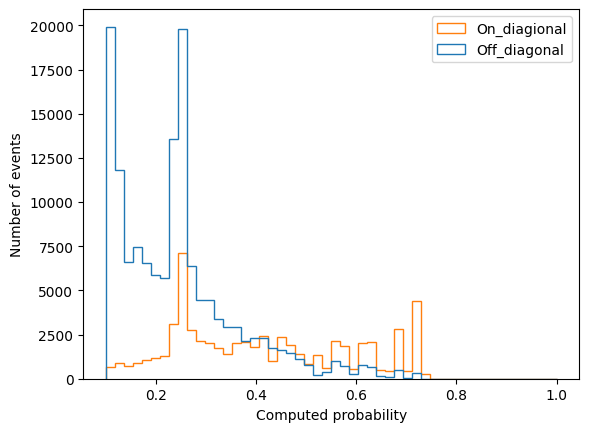

<Figure size 640x480 with 0 Axes>

In [22]:
test_prob = model.rf_model.predict_proba(model.X_test_scaled)[:,1]
print(test_prob)
model.plot_probs(test_prob)

In [23]:
test_f1, prec, rec = model.test()


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/surajrai1900/iwcd_gbdt/train_test_tree.py:166: RuntimeWarning: invalid value encountered in double_scalars
  mod_f1 = (1+w)*(prec*rec)/(w*prec + rec)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/surajrai1900/iwcd_gbdt/train_test_tree.py:166: RuntimeWarning: invalid value encountered in double_scalars
  mod_f1 = (1+w)*(prec*rec)/(w*prec + rec)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Prec

In [24]:
print(test_f1, prec, rec)

0.538577768259747 0.5118961461914239 0.7284137353972903


In [25]:
feature_imp = model.get_features_importances()
print(feature_imp)

{'h5_momentum': 0.6439497702429251, 'h5_towall': 0.30426428670574235, 'h5_dwall': 0.022423909647645023, 'h5_reco_mom_e': 0.02936203340368771, 'h5_vetos': 0.0}


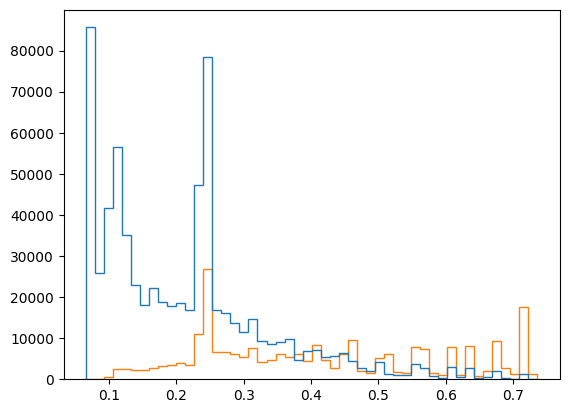

(0.5584207578735593, 0.8332721204669211, 0.210786115633041)

In [26]:
model.test_on_train()

In [27]:
model.best_thresh

0.26153846153846155

In [28]:
model.X_test_scaled

array([[-0.12341243, -1.15565369, -0.71928699, -1.15924229,  2.94843401],
       [-0.1291602 , -0.87001649, -0.79782428, -0.28106146,  2.94843401],
       [ 1.35261146,  0.20587567, -0.44991565,  1.59443402, -0.33916309],
       ...,
       [-0.65831562,  1.12640327, -0.42272861, -0.45687825, -0.33916309],
       [-0.70866604, -0.87776739, -0.08685708, -0.24750212, -0.33916309],
       [ 1.54098394, -0.32843296,  0.83418759,  0.77900939, -0.33916309]])

In [29]:
sum(model.y_test)

62146

In [30]:
df = df_pandas(2)
df

,h5_momentum,h5_towall,h5_dwall,h5_reco_mom_e,h5_reco_mom_mu,h5_reco_mom_pi0,h5_reco_e_dwall,h5_reco_mu_dwall,h5_reco_pi0_dwall,h5_reco_e_towall,h5_reco_mu_towall,h5_reco_pi0_towall,h5_vetos,sig
0,390.431045,190.761574,64.608521,195.601089,396.211212,182.222870,96.302521,69.485870,40.318726,153.853203,190.813670,236.576526,0,1
1,366.958181,116.690399,64.063889,198.519302,365.972717,143.889603,58.443497,65.958130,66.610580,93.373962,122.936218,94.797974,0,1
2,820.022567,157.898254,146.082779,401.116699,500.035950,382.356476,130.241394,144.116730,151.163971,130.958557,162.748840,191.744995,1,0
3,245.318675,162.169028,4.677948,70.471001,290.330841,35.003506,11.607086,7.784149,25.579315,69.992909,104.375438,123.351176,0,0
4,190.499196,57.558180,39.656494,25.277693,189.667313,27.085699,32.237762,54.290863,56.393799,36.393268,61.813642,70.851217,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1164134,579.695268,491.248047,31.538849,328.118530,534.324768,322.024109,47.647659,35.816620,43.715607,286.661499,540.725586,264.857056,0,0
1164135,1001.043398,178.580150,129.652344,400.317322,543.000122,404.001007,138.309235,151.574570,151.156067,175.155650,191.757191,198.652914,1,0
1164136,945.693831,33.418060,31.273712,18.327209,187.888229,31.908281,9.576324,9.564362,-8.848511,597.651026,398.410923,NaN,1,0
1164137,889.349346,372.878450,298.996674,771.922607,916.760193,797.359070,280.669922,293.031433,291.351776,326.482257,384.074852,377.780664,0,0


In [31]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

In [32]:
model = train_test_tree.CutEngine(df, train_col = ['h5_momentum', 'h5_towall', 'h5_dwall', 'h5_reco_mom_mu','h5_vetos', 'sig'], lr = 0.01)

using gbdt model


In [33]:
model.train()

[0.51185189 0.45576032 0.42765737 ... 0.09038836 0.45962858 0.58798301]


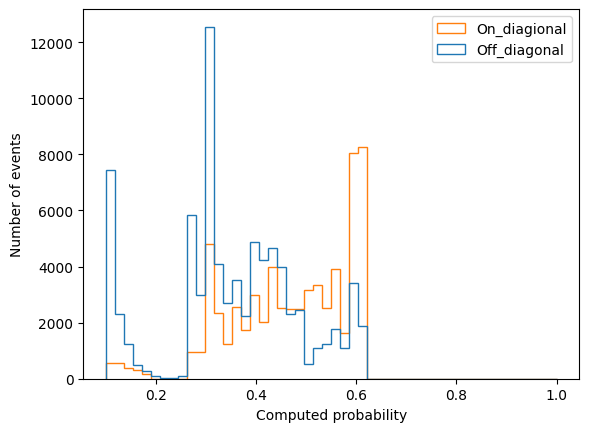

<Figure size 640x480 with 0 Axes>

In [34]:
test_prob = model.rf_model.predict_proba(model.X_test_scaled)[:,1]
print(test_prob)
model.plot_probs(test_prob)

In [35]:
test_f1, prec, rec = model.test()


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/surajrai1900/iwcd_gbdt/train_test_tree.py:166: RuntimeWarning: invalid value encountered in double_scalars
  mod_f1 = (1+w)*(prec*rec)/(w*prec + rec)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/surajrai1900/iwcd_gbdt/train_test_tree.py:166: RuntimeWarning: invalid value encountered in double_scalars
  mod_f1 = (1+w)*(prec*rec)/(w*prec + rec)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Prec

In [36]:
print(test_f1, prec, rec)

0.580217578112769 0.5447952803747477 0.859705554868242


In [37]:
feature_imp = model.get_features_importances()
print(feature_imp)

{'h5_momentum': 0.100420175579542, 'h5_towall': 0.001276811227671002, 'h5_dwall': 0.014514659834234538, 'h5_reco_mom_mu': 0.15004639420840388, 'h5_vetos': 0.7337419591501486}


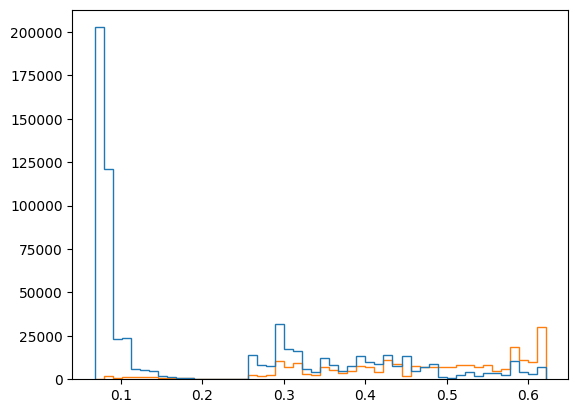

(0.44195741526710197, 0.8059335624284077, 0.13564870690486197)

In [38]:
model.test_on_train()

In [39]:
model.best_thresh

0.3153846153846154

In [40]:
model.X_test_scaled

array([[-1.08518742, -0.75568473, -0.25533173, -0.6263432 , -0.88059996],
       [-0.78351383,  0.2826013 , -0.99191652, -0.30176359, -0.88059996],
       [-0.46379255,  0.39601439,  0.27582928,  0.0496742 , -0.88059996],
       ...,
       [-0.58282158, -0.9997441 , -0.1344351 , -0.5991467 ,  1.13558942],
       [-0.95147894, -0.47932351, -0.20441001, -0.52054736, -0.88059996],
       [-1.52650705,  0.1203273 , -0.82942208, -1.20351901, -0.88059996]])

In [41]:
sum(model.y_test)

64664

In [42]:
df = df_pandas(3)
df

,h5_momentum,h5_towall,h5_dwall,h5_reco_mom_e,h5_reco_mom_mu,h5_reco_mom_pi0,h5_reco_e_dwall,h5_reco_mu_dwall,h5_reco_pi0_dwall,h5_reco_e_towall,h5_reco_mu_towall,h5_reco_pi0_towall,h5_vetos,sig
0,357.682680,190.761574,64.608521,251.625732,458.686859,183.660721,41.355560,27.491760,48.386200,214.160434,245.353337,211.020733,0,0
1,197.131473,104.812958,54.781342,85.326340,296.408112,220.460541,64.657715,63.641876,49.078644,153.024292,243.855469,109.496170,0,0
2,136.682374,481.660095,199.010498,191.666641,432.649261,139.791962,173.688568,134.225861,179.282700,458.864914,520.898858,494.148656,0,1
3,629.074737,169.846802,85.083420,381.309967,556.547119,485.354828,65.988800,66.591507,61.930511,158.443665,201.857117,161.331299,0,0
4,612.343903,574.656603,21.334351,627.487305,778.417480,631.732910,58.747086,17.900818,41.933990,526.903291,599.314393,560.168450,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147033,1129.409646,700.627380,1.895538,775.435730,914.885193,775.707031,94.645874,29.640259,59.765900,692.367065,760.993713,701.755798,0,0
1147034,762.779145,261.614868,60.631088,364.943909,523.743347,403.631989,56.375961,44.564209,66.872375,289.517944,321.209600,378.410173,0,0
1147035,570.130133,141.040481,23.028564,582.555054,768.801270,458.317535,46.259186,28.427521,34.372620,190.915211,270.893220,231.291059,0,0
1147036,424.911380,368.044983,125.783417,367.815887,579.801514,314.702240,124.889160,129.757202,134.189880,354.853577,387.064941,382.383728,1,0


In [43]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

In [44]:
model = train_test_tree.CutEngine(df, train_col = ['h5_momentum', 'h5_towall', 'h5_dwall', 'h5_reco_mom_pi0', 'h5_vetos', 'sig'], lr = 0.01)

using gbdt model


In [45]:
model.train()

[0.04168317 0.19029749 0.12850102 ... 0.04241259 0.03839835 0.08274411]


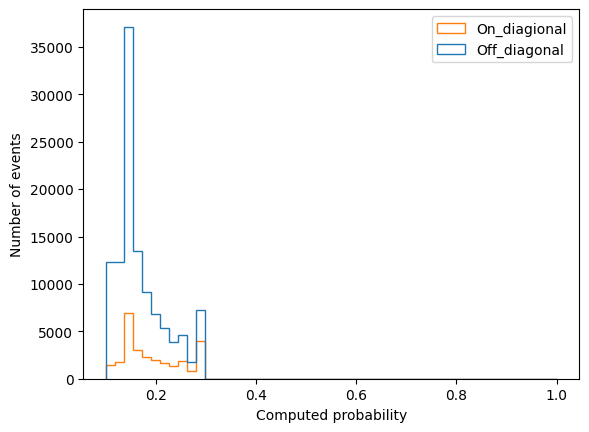

<Figure size 640x480 with 0 Axes>

In [46]:
test_prob = model.rf_model.predict_proba(model.X_test_scaled)[:,1]
print(test_prob)
model.plot_probs(test_prob)

In [47]:
test_f1, prec, rec = model.test()

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/surajrai1900/iwcd_gbdt/train_test_tree.py:166: RuntimeWarning: invalid value encountered in double_scalars
  mod_f1 = (1+w)*(prec*rec)/(w*prec + rec)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/surajrai1900/iwcd_gbdt/train_test_tree.py:166: RuntimeWarning: invalid value encountered in double_scalars
  mod_f1 = (1+w)*(prec*rec)/(w*prec + rec)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Prec

In [48]:
print(test_f1, prec, rec)

0.27044556224972416 0.24419061517736865 0.5848625394904887


In [49]:
feature_imp = model.get_features_importances()
print(feature_imp)

{'h5_momentum': 0.37767102821139986, 'h5_towall': 0.5889139087076197, 'h5_dwall': 0.019589618791610322, 'h5_reco_mom_pi0': 0.0, 'h5_vetos': 0.013825444289370197}


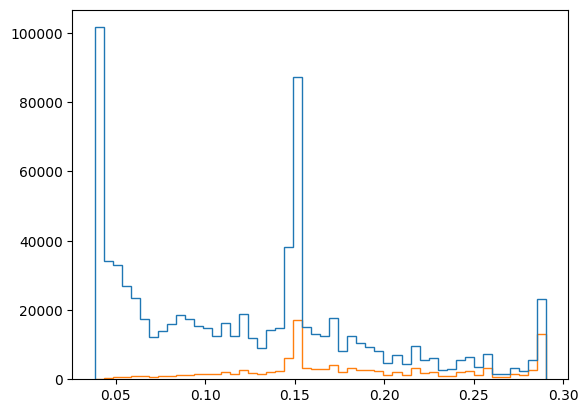

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/surajrai1900/iwcd_gbdt/train_test_tree.py:166: RuntimeWarning: invalid value encountered in double_scalars
  mod_f1 = (1+w)*(prec*rec)/(w*prec + rec)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/surajrai1900/iwcd_gbdt/train_test_tree.py:166: RuntimeWarning: invalid value encountered in double_scalars
  mod_f1 = (1+w)*(prec*rec)/(w*prec + rec)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Prec

(nan, 0.0, 0.0)

In [50]:
model.test_on_train()

In [51]:
model.best_thresh

0.15384615384615385

In [52]:
model.X_test_scaled

array([[ 5.09911024e-01, -1.09747498e+00, -1.12828298e+00,
        -1.59641090e-03, -4.22917022e-01],
       [-4.91110770e-01,  1.46136491e+00,  1.07461292e+00,
        -1.59615953e-03, -4.22917022e-01],
       [ 1.25702770e+00,  1.44802057e-01,  1.10204988e+00,
        -1.59484151e-03, -4.22917022e-01],
       ...,
       [ 4.65553396e-01, -1.11193248e+00, -4.76972597e-01,
        -1.59711354e-03, -4.22917022e-01],
       [ 4.07167917e-01, -1.34797251e+00, -8.84852412e-01,
        -1.59708899e-03,  2.36453003e+00],
       [ 3.91871580e-01, -5.98139289e-01, -4.93369807e-02,
        -1.59600958e-03, -4.22917022e-01]])

In [53]:
sum(model.y_test)

29754